This notebook is written to compare the c++ octree implementation for fixed neighbour search (available [here](https://github.com/jbehley/octree)). This is an adhoc comparison between the c++ code and python implementation of KDtree in MdAnalysis. It is done by generating files for different number of coordinates distributed uniformly in a [100,100,100] box. These files are then read by the C++ octree code, and respective build tiime and query times are resported for same coordinates dataset.

In [1]:
import numpy as np
from collections import defaultdict

In [2]:
def get_coords(box,Npoints):
    return (np.random.uniform(low=0,high=1.0,size=(Npoints,3))*box[:3]).astype(np.float32)

def _check_box(box):
        return box[:3] if box.shape == (6,) else box    

In [3]:
BOX = np.array([100.,100.,100.,90,90,90],dtype=np.float32)
CUTOFF = 10
NPOINTS = np.logspace(2, 5, num = 10, dtype = np.int)

In [4]:
for item in NPOINTS:
    coords = get_coords(BOX, item)
    np.savetxt('test'+str(item)+'.txt',coords)

KDTree used from previous benchmarks direclty, where it was tested against brute force and cellgrid. 

In [5]:
from MDAnalysis.lib.pkdtree import PeriodicKDTree
def kdtree_build(box, coords):
    pkdt = PeriodicKDTree(box,bucket_size=10)
    pkdt.set_coords(coords)
    return pkdt
def kdtree_query(struct, coords, pos, cutoff):
    struct.search(pos,cutoff)
    return coords[struct.get_indices()]

# Non Periodic KDtree

In [6]:
from Bio.KDTree import KDTree
def biopython_build(box, coords):
    kdtree = KDTree(dim=3)
    kdtree.set_coords(coords)
    return kdtree
def biopython_query(struct, coords, pos, cutoff):
    struct.search(pos,cutoff)
    return coords[struct.get_indices()]

In [18]:
import scipy.spatial as ss

def scipy_build(box, coords):
    kdtree = ss.cKDTree(coords)
    return kdtree

def scipy_query(struct, coords, pos, cutoff):
    return coords[struct.query_ball_point(pos, cutoff)]

We only check the query at the midpoint of the box and cutoff radius of 10 units.

In [7]:
#coords = np.loadtxt('test.txt',dtype = np.float32)
pos = BOX[:3]/2
pos

array([50., 50., 50.], dtype=float32)

# Single Query

In [20]:
res = defaultdict(list)
for item in NPOINTS:
    coords = np.loadtxt('test'+str(item)+'.txt',dtype = np.float32)
    buildpkd = %timeit -o -q kdtree_build(BOX, coords)
    buildkd = %timeit -o -q biopython_build(BOX, coords)
    buildskd = %timeit -o -q scipy_build(BOX, coords)
    res['buildpkd'].append(buildpkd.average)
    res['buildkd'].append(buildkd.average)
    res['buildskd'].append(buildskd.average)
    
    pkdt = kdtree_build(BOX,coords)
    querypkd = %timeit -o -q kdtree_query(pkdt, coords, pos, CUTOFF)
    kdt =  biopython_build(BOX, coords)
    querykd = %timeit -o -q biopython_query(kdt, coords, pos, CUTOFF)
    skdt =  scipy_build(BOX, coords)
    queryskd = %timeit -o -q scipy_query(skdt, coords, pos, CUTOFF)
    res['querypkd'].append(querypkd.average)
    res['querykd'].append(querykd.average)
    res['queryskd'].append(queryskd.average)
    res['N'].append(item)

# Data collected from outside the notebook

In [21]:
res_octree = defaultdict(list)
res_octree['build'] = [0.000035900, 0.000085800, 0.000157700, 0.000229500, 
                           0.001341700, 0.002891500, 0.002448400, 0.008294600,
                           0.017574700, 0.038262600]
res_octree['query'] = [0.000052300, 0.000088600, 0.000058300, 0.000050400 , 0.000126900, 
                       0.000096600, 0.000070400, 0.000115700, 0.000162800, 0.000237400]
res_octree['N'] = res['N']

All the points within Cutoff distance


# Comparison between Octree and KDtree


In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

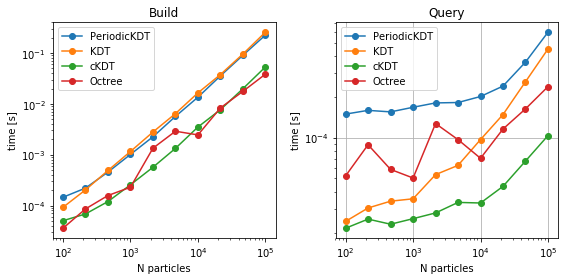

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(1/2))

ax = axes[0]
ax.plot(res['N'], res['buildpkd'], 'o-', label='PeriodicKDT')
ax.plot(res['N'], res['buildkd'], 'o-', label='KDT')
ax.plot(res['N'], res['buildskd'], 'o-', label='cKDT')
ax.plot(res_octree['N'], res_octree['build'], 'o-', label='Octree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Build')
ax.legend()

ax = axes[1]
ax.plot(res['N'], res['querypkd'], 'o-', label='PeriodicKDT')
ax.plot(res['N'], res['querykd'], 'o-', label='KDT')
ax.plot(res['N'], res['queryskd'], 'o-', label='cKDT')
ax.plot(res_octree['N'], res_octree['query'], 'o-', label='Octree')
ax.set(xlabel='N particles', ylabel='time [s]', xscale='log', yscale='log', title='Query')
ax.grid(True)
ax.legend()

fig.tight_layout()

OCtree with index based construction is a promising data structure to replace distance based calculations.  

# Lets check the variation with cutoff radius

To see the variation, which is useful for the general use cases in MDAnalysis, lets chose number of particles to be ~40k from above. 

In [12]:
cutoff = np.linspace(2,10,num = 9, dtype = np.float32)

In [31]:
res = defaultdict(list)
coords = np.loadtxt('test'+str(NPOINTS[8])+'.txt',dtype = np.float32)
for item in cutoff:
    pkdt = kdtree_build(BOX,coords)
    query = %timeit -o -q kdtree_query(pkdt, coords, pos, item)
    
    kdt =  biopython_build(BOX, coords)
    querykd = %timeit -o -q biopython_query(kdt, coords, pos, item)
    
    skdt =  scipy_build(BOX, coords)
    queryskd = %timeit -o -q scipy_query(skdt, coords, pos, item)
    
    res['querypkd'].append(query.average)
    res['querykd'].append(querykd.average)
    res['queryskd'].append(queryskd.average)
    res['cutoff'].append(item)

In [32]:
res_octree = defaultdict(list)
res_octree['query'] = [ 0.000065300 , 0.000057000, 0.000060200, 0.000063000,
                       0.000057400, 0.000090000, 0.000191700, 0.000117500, 0.000126000]
res_octree['cutoff'] = res['cutoff']

In [33]:
res,res_octree

(defaultdict(list,
             {'cutoff': [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
              'querykd': [5.8305900370968244e-05,
               6.350446577416733e-05,
               7.220464906921343e-05,
               7.722712367041302e-05,
               0.00010181999861462309,
               0.00017218958617221296,
               0.00020970867238273577,
               0.00024796699414894515,
               0.00025969838771769513],
              'querypkd': [0.00017924900584122432,
               0.00018303655848638819,
               0.00019221882803997558,
               0.0001966091069592429,
               0.00022167238458392345,
               0.000247026767598332,
               0.0002926681687157335,
               0.0003241163211142911,
               0.0003675536754141961],
              'queryskd': [2.768878565569009e-05,
               2.84960044996946e-05,
               3.2438657471045316e-05,
               3.263859300973958e-05,
               3.7114034300

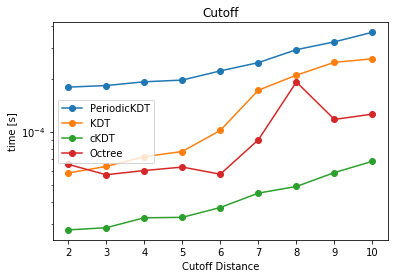

In [34]:
fig, ax = plt.subplots()
ax.plot(res['cutoff'], res['querypkd'], 'o-', label='PeriodicKDT')
ax.plot(res['cutoff'], res['querykd'], 'o-', label='KDT')
ax.plot(res['cutoff'], res['queryskd'], 'o-', label='cKDT')
ax.plot(res_octree['cutoff'], res_octree['query'], 'o-', label='Octree')
ax.set(xlabel='Cutoff Distance', ylabel='time [s]', yscale='log', title='Cutoff')
ax.legend()